# Regression Analysis of Temporal Processes (Class 6a) - Survival

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/melindasong/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1a. One-time events

In [2]:
pan = pd.read_csv('panel-for-R.csv')

(slide 39)

In [39]:
variables = ['age', 'year', 'sex', 'idnum', 'panelwave', 'wrkstat', 'educ', 'region']
sub = pan[variables].copy()

sub['ft'] = np.where(pd.isna(sub['wrkstat']), np.nan, 
                     np.where(sub['wrkstat']==1, 1, 0))

In [40]:
# drop people working full-time in wave 1
sub['drop'] = np.where((sub['ft']==1) & (sub['panelwave']==1), 1, 0)

In [41]:
# get idnum of subjects we're going to drop
drop_idnum = sub.idnum[sub['drop']==1].unique()

In [42]:
# subset the sub dataframe to include subjects whose idnum is not in the drop_idnum list
subpt = sub.loc[~sub['idnum'].isin(drop_idnum)].copy()

In [43]:
subpt['ytwo'] = np.where(pd.isna(subpt['ft']), np.nan, 
                         np.where((subpt['ft']==1) & (subpt['panelwave']==2), 2, 0))
subpt_two = subpt.loc[subpt['ytwo']==2, 'idnum'].unique()
subpt['ytwo_two'] = np.where(subpt['idnum'].isin(subpt_two), 2, 0)

subpt['ythree'] = np.where(pd.isna(subpt['ft']), np.nan, 
                         np.where((subpt['ft']==1) & (subpt['panelwave']==3), 3, 0))
subpt_three = subpt.loc[subpt['ythree']==3, 'idnum'].unique() 
subpt['ythree_three'] = np.where(subpt['idnum'].isin(subpt_three), 3, 0)

In [44]:
subpt.loc[:, 'combo'] = subpt['ytwo_two'].astype(str) + subpt['ythree_three'].astype(str)

In [35]:
# (slide 42)
subpt['combo'].value_counts()

00    2454
23     222
20     165
03     159
Name: combo, dtype: int64

In [10]:
subpt.groupby(['ft', 'combo']).size()

ft   combo
0.0  00       1891
     03        105
     20         84
     23         74
1.0  03         53
     20         55
     23        148
dtype: int64

In [45]:
# (slide 43)
subpt.loc[(subpt['combo']=='20') & (subpt['year']==2010), 'ft'] = np.nan
subpt.loc[(subpt['combo']=='23') & (subpt['year']==2010), 'ft'] = np.nan
subpt.groupby(['ft', 'combo']).size()

ft   combo
0.0  00       1891
     03        105
     20         55
     23         74
1.0  03         53
     20         55
     23         74
dtype: int64

In [46]:
# (slide 44)
subpt['nyear'] = subpt.loc[:, 'year'] - 2006
lo1 = smf.glm('ft ~ C(nyear)', data = subpt[subpt['year']>2006], family=sm.families.Binomial()).fit()
lo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                 1309
Model:                            GLM   Df Residuals:                     1307
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -522.01
Date:                Mon, 13 Aug 2018   Deviance:                       1044.0
Time:                        23:28:04   Pearson chi2:                 1.31e+03
No. Iterations:                     5   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.6187      0.096    -16.796      0.000      -1.808      -1.430
C(nyear)[T.4.0]    -0.5764      0.174     -3.314      0.001      -0.917      -0.236
===================================================================================
"""

In [13]:
# slide 47
np.exp(lo1.params)

Intercept          0.198157
C(nyear)[T.4.0]    0.561902
dtype: float64

In [14]:
# (slide 48)
lo2 = smf.glm('ft ~ C(nyear) + age + educ + sex', data = subpt[subpt['year']>2006], 
              family = sm.families.Binomial()).fit()
lo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                 1292
Model:                            GLM   Df Residuals:                     1287
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -442.45
Date:                Mon, 13 Aug 2018   Deviance:                       884.90
Time:                        23:07:10   Pearson chi2:                 1.20e+03
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1529      0.607      0.252      0.801      -1.038       1.343
C(nyear)[T.4.0]    -0.3444      0.186     -1.851      0.064      -0.709       0.020
age                -0.0568      0.005    -10.825      0.000      -0.067      -0.046
educ                0.0905      0.030      3.058      0.002       0.032       0.149
sex                -0.1435      0.196     -0.730      0.465      -0.529       0.242
===================================================================================
"""

In [15]:
# (slide 52)
lo3 = smf.glm('ft ~ C(nyear) + age + educ + sex', 
              data = subpt[(subpt.year > 2006) & (subpt.age > 22) & (subpt.age < 60)],
              family = sm.families.Binomial()).fit()
lo3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                  619
Model:                            GLM   Df Residuals:                      614
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -329.37
Date:                Mon, 13 Aug 2018   Deviance:                       658.74
Time:                        23:07:16   Pearson chi2:                     623.
No. Iterations:                     4   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4189      0.747     -0.561      0.575      -1.882       1.044
C(nyear)[T.4.0]    -0.4991      0.209     -2.387      0.017      -0.909      -0.089
age                -0.0355      0.009     -3.971      0.000      -0.053      -0.018
educ                0.1084      0.033      3.295      0.001       0.044       0.173
sex                -0.3051      0.225     -1.357      0.175      -0.746       0.136
===================================================================================
"""

In [17]:
# (slide 55)
lo4 = smf.glm('ft ~ C(nyear)*C(sex) + age + educ', 
              data = subpt[(subpt.year > 2006) & (subpt.age > 22) & (subpt.age < 60)],
              family = sm.families.Binomial()).fit()
lo4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                  619
Model:                            GLM   Df Residuals:                      613
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -328.20
Date:                Mon, 13 Aug 2018   Deviance:                       656.40
Time:                        23:08:57   Pearson chi2:                     616.
No. Iterations:                     4   Covariance Type:             nonrobust
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.6097      0.636     -0.958      0.338      -1.857       0.637
C(nyear)[T.4.0]                  -1.1184      0.476     -2.351      0.019      -2.051      -0.186
C(sex)[T.2.0]                    -0.5111      0.261     -1.955      0.051      -1.023       0.001
C(nyear)[T.4.0]:C(sex)[T.2.0]     0.7893      0.530      1.488      0.137      -0.250       1.829
age                              -0.0354      0.009     -3.932      0.000      -0.053      -0.018
educ                              0.1107      0.033      3.348      0.001       0.046       0.176
=================================================================================================
"""

## 1b. Repeated events

We need to undo the dropping of any observations:

In [18]:
subpt['ft'] = np.where(pd.isna(subpt['wrkstat']), np.nan, 
                     np.where(subpt['wrkstat']==1, 1, 0))

In [19]:
# slide 60
subpt['lft'] = np.where((((subpt['combo']=='20') & (subpt['year']==2010)) | 
                        ((subpt['combo']=='23') & (subpt['year']==2010))), 1,
                       np.where((((subpt['combo']=='20') & (pd.isna(subpt['year'])))| 
                        ((subpt['combo']=='23') & (pd.isna(subpt['year'])))), np.nan, 0))

In [16]:
# slide 62
smf.glm('ft ~ nyear', data = subpt[subpt['year']>2006], family = sm.families.Binomial()).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                 1412
Model:                            GLM   Df Residuals:                     1410
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -666.91
Date:                Wed, 18 Jul 2018   Deviance:                       1333.8
Time:                        23:25:36   Pearson chi2:                 1.41e+03
No. Iterations:                     4   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8570      0.217     -8.565      0.000      -2.282      -1.432
nyear          0.1192      0.069      1.723      0.085      -0.016       0.255
==============================================================================
"""

In [20]:
# slide 64

lo2 = smf.glm('ft ~ C(nyear) + lft', data = subpt[subpt['year']>2006], family = sm.families.Binomial()).fit()
lo2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                 1412
Model:                            GLM   Df Residuals:                     1409
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -583.24
Date:                Mon, 13 Aug 2018   Deviance:                       1166.5
Time:                        23:10:47   Pearson chi2:                 1.41e+03
No. Iterations:                     5   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -1.6187      0.096    -16.796      0.000      -1.808      -1.430
C(nyear)[T.4.0]    -0.5764      0.174     -3.314      0.001      -0.917      -0.236
lft                 3.1319      0.263     11.926      0.000       2.617       3.647
===================================================================================
"""

In [21]:
# slide 66

lo3 = smf.glm('ft ~ C(nyear) + lft + sex + educ + age', data = subpt[subpt['year']>2006], family = sm.families.Binomial()).fit()
lo3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                     ft   No. Observations:                 1394
Model:                            GLM   Df Residuals:                     1388
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -503.38
Date:                Mon, 13 Aug 2018   Deviance:                       1006.8
Time:                        23:10:59   Pearson chi2:                 1.28e+03
No. Iterations:                     6   Covariance Type:             nonrobust
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1068      0.572     -0.187      0.852      -1.228       1.015
C(nyear)[T.4.0]    -0.3556      0.185     -1.922      0.055      -0.718       0.007
lft                 2.5970      0.280      9.282      0.000       2.049       3.145
sex                -0.1171      0.183     -0.641      0.522      -0.475       0.241
educ                0.0957      0.028      3.400      0.001       0.041       0.151
age                -0.0535      0.005    -10.833      0.000      -0.063      -0.044
===================================================================================
"""

## 1c. Multiple outcomes 

In [47]:
# (slide 70)
subpt.loc[subpt['wrkstat']==1, 'work'] = 3
subpt.loc[subpt['wrkstat']==2, 'work'] = 2
subpt.loc[subpt['wrkstat']>2, 'work'] = 1

In [23]:
# (slide 71)
from statsmodels.discrete.discrete_model import MNLogit

MNLogit.from_formula('work ~ 1 + panelwave', data = subpt[subpt['year']>2006]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.832511
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   work   No. Observations:                 1412
Model:                        MNLogit   Df Residuals:                     1408
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:                0.002430
Time:                        23:12:57   Log-Likelihood:                -1175.5
converged:                       True   LL-Null:                       -1178.4
                                        LLR p-value:                   0.05704
==============================================================================
    work=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.9969      0.401     -2.487      0.013      -1.782      -0.211
panelwave     -0.2712      0.164     -1.652      0.099      -0.593       0.051
------------------------------------------------------------------------------
    work=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.8153      0.357     -5.088      0.000      -2.514      -1.116
panelwave      0.1955      0.141      1.389      0.165      -0.080       0.471
==============================================================================
"""

In [24]:
# (slide 73)
MNLogit.from_formula('work ~ 1 + panelwave + sex + educ + age', data = subpt[subpt['year']>2006]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.732061
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   work   No. Observations:                 1394
Model:                        MNLogit   Df Residuals:                     1384
Method:                           MLE   Df Model:                            8
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:                  0.1253
Time:                        23:13:18   Log-Likelihood:                -1020.5
converged:                       True   LL-Null:                       -1166.6
                                        LLR p-value:                 1.813e-58
==============================================================================
    work=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.4716      0.725     -2.030      0.042      -2.892      -0.051
panelwave     -0.2406      0.170     -1.415      0.157      -0.574       0.093
sex            0.6445      0.207      3.115      0.002       0.239       1.050
educ           0.0682      0.028      2.458      0.014       0.014       0.123
age           -0.0296      0.005     -6.381      0.000      -0.039      -0.021
------------------------------------------------------------------------------
    work=3       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.3350      0.657     -0.510      0.610      -1.623       0.953
panelwave      0.3442      0.157      2.191      0.028       0.036       0.652
sex           -0.0552      0.175     -0.315      0.753      -0.398       0.288
educ           0.1143      0.027      4.231      0.000       0.061       0.167
age           -0.0656      0.005    -13.546      0.000      -0.075      -0.056
==============================================================================
"""

## 2. Continuous survival analysis

To plot the Kaplan-Meier survival estimates, we need to use the `lifelines` module

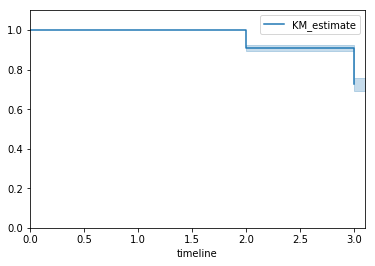

In [26]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

# get rid of NA's in the subset of data we care about, otherwise the fitter will throw an error. 
df = subpt.loc[subpt['year']>2006, ['panelwave', 'ft']]
df = df.dropna()

# fit the duration and event columns
kmf.fit(df['panelwave'], df['ft'])

# plot the fitted model
kmf.plot(xlim = (0, 3.1), ylim = (0, 1.1))

In [38]:
# Gather the variables to be fitted and remove NA's
#subpt = subpt.loc[subpt['year']>2006, ['ft', 'age', 'educ', 'sex']]
#df = df.dropna()

In [57]:
# slide 86

from lifelines import CoxPHFitter

# drop observations who were already deceased in 2010
subpt.loc[(subpt['combo']=='20') & (subpt['year']==2010), 'ft'] = np.nan
subpt.loc[(subpt['combo']=='23') & (subpt['year']==2010), 'ft'] = np.nan
subpt.dropna(inplace=True)

# working with a subset of the data
subpt2 = subpt[['ft', 'age', 'educ', 'sex']].copy()
subpt2['time'] = 1

cph = CoxPHFitter()
cph.fit(subpt2, duration_col = 'time', event_col = 'ft')
cph.print_summary()

n=2284, number of events=181

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
age  -0.0425     0.9584    0.0044 -9.7644 0.0000     -0.0511     -0.0340  ***
educ  0.1011     1.1063    0.0262  3.8530 0.0001      0.0497      0.1525  ***
sex  -0.0038     0.9962    0.1685 -0.0226 0.9820     -0.3341      0.3265     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.741
Likelihood ratio test = 120.964 on 3 df, p=0.00000


<br>
(slide 92)

To fit the model using the breslow method, we can use `PHReg` from the `statsmodels.duration.hazard_regression` module, where the default method is 'breslow'

In [58]:
from statsmodels.duration.hazard_regression import PHReg

coxph2 = PHReg(endog = subpt2['time'], exog = subpt2[['age', 'educ', 'sex']], status = subpt2['ft']).fit()
coxph2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: PHReg
==========================================================
Model:                   PH Reg      Sample size:     2284
Dependent variable:      time        Num. events:     181 
Ties:                    Breslow                          
----------------------------------------------------------
      log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
----------------------------------------------------------
age  -0.0407    0.0044 0.9601 -9.3530 0.0000 0.9519 0.9683
educ  0.0946    0.0262 1.0992  3.6127 0.0003 1.0442 1.1571
sex   0.0141    0.1684 1.0142  0.0835 0.9334 0.7291 1.4107
==========================================================
Confidence intervals are for the hazard ratios
"""

In [59]:
# see the 'Efron' method results
PHReg(endog = subpt2['time'], exog = subpt2[['age', 'educ', 'sex']], status = subpt2['ft'], ties='efron').fit().summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: PHReg
==========================================================
Model:                    PH Reg     Sample size:     2284
Dependent variable:       time       Num. events:     181 
Ties:                     Efron                           
----------------------------------------------------------
      log HR log HR SE   HR      t    P>|t|  [0.025 0.975]
----------------------------------------------------------
age  -0.0425    0.0044 0.9584 -9.7644 0.0000 0.9502 0.9666
educ  0.1011    0.0262 1.1063  3.8530 0.0001 1.0509 1.1647
sex  -0.0038    0.1685 0.9962 -0.0226 0.9820 0.7159 1.3862
==========================================================
Confidence intervals are for the hazard ratios
"""

In [62]:
# slide 93

# model for all ages
df = subpt.loc[subpt['year']>2006, ['ft', 'age', 'educ', 'sex']]
df = df.dropna()

df['time'] = 1

cph = CoxPHFitter()
cph.fit(df, duration_col = 'time', event_col = 'ft')
cph.print_summary()

n=1290, number of events=181

        coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
age  -0.0508     0.9504    0.0045 -11.3599 0.0000     -0.0596     -0.0421  ***
educ  0.0801     1.0834    0.0260   3.0855 0.0020      0.0292      0.1310   **
sex  -0.1475     0.8629    0.1693  -0.8712 0.3836     -0.4793      0.1843     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.782
Likelihood ratio test = 157.481 on 3 df, p=0.00000


In [48]:
# (slide 93)

# subset the df using the additional age filters
df = subpt.loc[(subpt['year']>2006) & (subpt['age']>22) & (subpt['age']<60), ['ft', 'age', 'educ', 'sex']]
df = df.dropna()

# assign time = 2 if age is between 23 to 59
df.loc[(subpt['age']>22) & (subpt['age']<60), 'time'] = 2

cph = CoxPHFitter()
cph.fit(df, duration_col = 'time', event_col = 'ft')
cph.print_summary()

n=715, number of events=225

        coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
age  -0.0281     0.9723    0.0062 -4.5562 0.0000     -0.0402     -0.0160  ***
educ  0.0935     1.0980    0.0229  4.0892 0.0000      0.0487      0.1384  ***
sex  -0.2780     0.7573    0.1501 -1.8523 0.0640     -0.5721      0.0162    .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.640
Likelihood ratio test = 41.640 on 3 df, p=0.00000


<br>
The Schoenfeld test (slide 96) - We can obtain the Schoenfeld residuals to check for any violation of the proportional hazards assumptions. 

In [92]:
coxph2.schoenfeld_residuals

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

(0, 3.1)

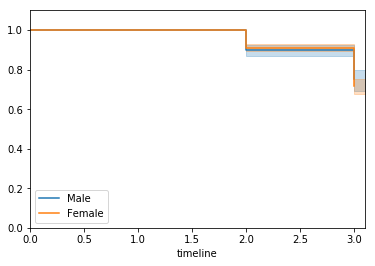

In [84]:
# (slide 97)
df = subpt.loc[subpt['year']>2006, ['panelwave', 'sex', 'ft']]
df = df.dropna()
df['female'] = np.where(df['sex']==2, 1, 0)

ax = plt.subplot(111)

# plot the female and male lines separately
kmf.fit(df.loc[df['female']==0, 'panelwave'], df.loc[df['female']==0, 'ft'], label = 'Male')
ax = kmf.plot(ax=ax)

kmf.fit(df.loc[df['female']==1, 'panelwave'], df.loc[df['female']==1, 'ft'], label = 'Female')
ax = kmf.plot(ax=ax)

# plot the fitted model
plt.ylim(0, 1.1)
plt.xlim(0, 3.1)

In [87]:
subpt.loc[(subpt.year == 2008) & (subpt.sex==1), 'ft'].mean()

0.17796610169491525

In [88]:
subpt.loc[(subpt.year == 2010) & (subpt.sex==1), 'ft'].mean()

0.1657754010695187

In [89]:
subpt.loc[(subpt.year == 2008) & (subpt.sex==2), 'ft'].mean()

0.15992647058823528

In [90]:
subpt.loc[(subpt.year == 2010) & (subpt.sex==2), 'ft'].mean()

0.2157303370786517